
# **Installation**

In [1]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (1.8.0)
Requirement not upgraded as not directly required: grpcio>=1.8.6 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (1.12.0)
Requirement not upgraded as not directly required: termcolor>=1.1.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (1.1.0)
Requirement not upgraded as not directly required: gast>=0.2.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (0.2.0)
Requirement not upgraded as not directly required: astor>=0.6.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (0.6.2)
Requirement not upgraded as not directly required: wheel>=0.26 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (0.31.1)
Requirement not upgraded as not directly required: absl-py>=0.1.6 in /usr/local/lib/python3.6/dist-packages (from tensorflow) (0.2.2)
Requirement not upgraded as not directly required: tensorboard<1.9.0,>=1.8.0 in /usr/local/lib/python3.6/dis

In [2]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.8.0
Eager execution: True


# **Import**

In [47]:
train_dataset_url = "http://hugoborsier1.monsite-orange.fr/file/7d6084e4c471bb1a04730f46aba62a1d.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))


Local copy of the dataset file: /content/.keras/datasets/7d6084e4c471bb1a04730f46aba62a1d.csv


In [48]:
!head -n5 {train_dataset_fp}

**10 Questions : **


* Q1
* Q2
* Q3
* Q4
* Q5
* Q6
* Q7
* Q8
* Q9
* Q10

**Réponse :**
Menu


In [0]:
def parse_csv(line):
  example_defaults = [[0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0]]  # sets field types
  parsed_line = tf.decode_csv(line, example_defaults)
  # First 10 fields are features, combine into single tensor
  features = tf.reshape(parsed_line[:-1], shape=(10,))
  # Last field is the label
  label = tf.reshape(parsed_line[-1], shape=())
  return features, label

In [50]:
train_dataset = tf.data.TextLineDataset(train_dataset_fp)
train_dataset = train_dataset.skip(1)             # skip the first header row
train_dataset = train_dataset.map(parse_csv)      # parse each row
train_dataset = train_dataset.shuffle(buffer_size=1000)  # randomize
train_dataset = train_dataset.batch(32)

# View a single example entry from a batch
features, label = tfe.Iterator(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])

example features: tf.Tensor([0. 1. 1. 0. 1. 1. 0. 2. 2. 1.], shape=(10,), dtype=float32)
example label: tf.Tensor(1, shape=(), dtype=int32)


In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=(10,)),  # input shape required
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(5)
])

In [0]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


def grad(model, inputs, targets):
  with tfe.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, model.variables)

In [0]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

In [67]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of 32
  for x, y in tfe.Iterator(train_dataset):
    # Optimize the model
    grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=tf.train.get_or_create_global_step())

    # Track progress
    epoch_loss_avg(loss(model, x, y))  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 2.320, Accuracy: 3.279%
Epoch 050: Loss: 1.362, Accuracy: 40.984%
Epoch 100: Loss: 1.261, Accuracy: 47.541%
Epoch 150: Loss: 1.201, Accuracy: 54.098%
Epoch 200: Loss: 1.162, Accuracy: 57.377%


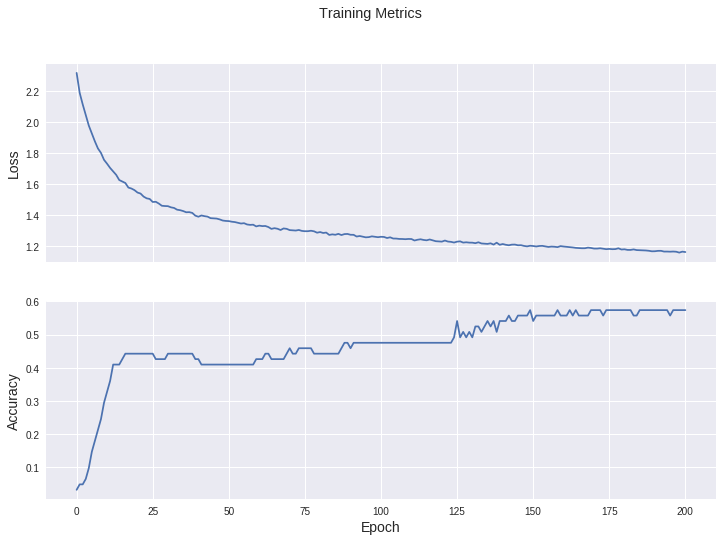

In [78]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()

In [75]:
test_url = "http://hugoborsier1.monsite-orange.fr/file/01838b80b0c193a3ac00a0aca311f323.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

test_dataset = tf.data.TextLineDataset(test_fp)
test_dataset = test_dataset.skip(1)             # skip header row
test_dataset = test_dataset.map(parse_csv)      # parse each row with the funcition created earlier
test_dataset = test_dataset.shuffle(1000)       # randomize
test_dataset = test_dataset.batch(32)           # use the same batch size as the training set

8192/85 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [76]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in tfe.Iterator(test_dataset):
  prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

InvalidArgumentError: ignored

In [87]:
class_ids = ["yolo","Menu lourd", "Menu léger", "Menu normal", "Menu exotique"]

predict_dataset = tf.convert_to_tensor([
    [1.0,0,1,1,1,0,1,1,2,1],
    [1.0,0,1,1,1,0,1,1,2,1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  name = class_ids[class_idx]
  print("Example {} prediction: {}".format(i, name))

Example 0 prediction: Menu exotique
Example 1 prediction: Menu exotique
